In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# فصل ۵ — درخت‌های تصمیم و گونه‌ها
## درس ۸: مدیریت مقادیر گمشده و متغیرهای دسته‌ای در درخت‌ها



درخت‌های تصمیم معمولاً به‌عنوان مدلی معرفی می‌شوند که «برای داده‌های جدولیِ نامرتب هم تقریباً بدون دردسر کار می‌کند». این حرف تا حدی درست است: درخت‌ها انعطاف‌پذیرند، غیرخطی‌اند و به مقیاس‌بندی ویژگی‌ها نیاز ندارند. اما دو واقعیت بسیار رایج همچنان به مهندسی دقیق نیاز دارند:

1. **مقادیر گمشده** (NaN / null / خالی) — ناشی از نقص جمع‌آوری داده، قطع حسگرها، فرم‌های ناقص، یا خطاهای join.
2. **متغیرهای دسته‌ای (Categorical)** — رشته‌ها و برچسب‌های گسسته مثل `"HIGH"`، `"LOW"`، `"Yes"`، `"No"`، `"Premium"`، `"East"`.

بسیاری از پیاده‌سازی‌های حرفه‌ایِ درخت‌ها، ترفندهای سطحِ مدل برای مدیریت missingness (مثل مسیر پیش‌فرض، surrogate splits یا هدایت احتمالی) و برای ویژگی‌های دسته‌ای (مثل آمار هدفِ مرتب‌شده) دارند. با این حال، **درخت‌های استاندارد scikit-learn یعنی `DecisionTreeClassifier/Regressor` به‌طور مستقیم NaN را نمی‌پذیرند** و ورودیِ صرفاً عددی انتظار دارند. بنابراین در عمل، معمولاً هر دو مسئله را در یک **خط لوله‌ی پیش‌پردازش (preprocessing pipeline)** حل می‌کنیم.

در این درس دقیقاً یاد می‌گیرید **چطور این کار را درست انجام دهید** (و چطور از leakage جلوگیری کنید)؛ آن هم با چند دیتاست مختلف از همین مخزن.



### اهداف یادگیری

در پایان این درس باید بتوانید:

- توضیح دهید چرا missingness و ویژگی‌های categorical در کتابخانه‌های مختلف «خاص» هستند.
- الگوهای مقادیر گمشده را تشخیص دهید و راهبرد مناسب انتخاب کنید (حذف، impute، indicator، یا مدیریتِ بومیِ مدل).
- دسته‌ای‌ها را برای درخت‌ها encode کنید (one-hot، ordinal، frequency، target encoding) و معامله‌ی بایاس/واریانس را بفهمید.
- با `ColumnTransformer` و `Pipeline` خط‌لوله‌های **بدون leakage** بسازید و با cross-validation ارزیابی کنید.
- یک **target encoder ایمن** (out-of-fold) پیاده‌سازی کنید و بدانید چه زمانی ارزش پیچیدگی را دارد.



### راه‌اندازی محیط

از `pandas`، `numpy`، `matplotlib` و `scikit-learn` استفاده می‌کنیم.

**نکته مهم:** مسیر دیتاست‌ها نسبت به محل نوت‌بوک است. برای نوت‌بوک‌های فصل ۵ از این الگو استفاده کنید:

- `../../../Datasets/Classification/...`
- `../../../Datasets/Regression/...`
- `../../../Datasets/Clustering/...` (در این درس استفاده نمی‌شود، اما برای سازگاری ذکر شده است)

اگر این نوت‌بوک را خارج از مخزن اجرا می‌کنید، مسیرها را متناسب اصلاح کنید.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_absolute_error, mean_squared_error
)
# sklearn 1.4+ deprecates mean_squared_error(..., squared=False) in favor of root_mean_squared_error
try:
    from sklearn.metrics import root_mean_squared_error
except Exception:
    def root_mean_squared_error(y_true, y_pred):
        return mean_squared_error(y_true, y_pred, squared=False)

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text

np.random.seed(42)



## ۱) مقادیر گمشده در درخت‌های تصمیم: دقیقاً چه اتفاقی می‌افتد؟

### ۱.۱ چرا مقدار گمشده «فقط یک مقدار دیگر» نیست؟
یک split در CART معمولاً یک ویژگی را با یک آستانه (برای عددی) یا عضویت (برای دسته‌ای) مقایسه می‌کند و نمونه را به چپ یا راست می‌فرستد. اگر مقدار یک ویژگی گمشده باشد، قانون واضحی برای هدایت نمونه وجود ندارد.

در یک split عددی، شرطی مانند زیر را ارزیابی می‌کنیم:

$$
x_j \le t
$$

اما اگر $x_j$ برابر NaN باشد، مقایسه تعریف‌نشده است. به همین دلیل بسیاری از کتابخانه‌ها از شما می‌خواهند قبل از آموزشِ یک درخت کلاسیک، تکلیف missingness را روشن کنید.

### ۱.۲ راهبردهای رایج در پیاده‌سازی‌های مختلف (مفهومی)
کتابخانه‌های مختلف از راهبردهای متفاوتی استفاده می‌کنند:

- **حذف سطرها** با ویژگی‌های گمشده (ساده ولی ممکن است داده را بایاس کند و سیگنال را دور بریزد).
- **Impute** کردن مقادیر گمشده (میانگین/میانه برای عددی، مد برای دسته‌ای، یا یک دسته‌ی مشخص برای “Missing”).
- **Missing indicator**: افزودن ویژگی دودویی $m_j = \mathbb{1}[x_j \text{ is missing}]$ تا درخت بتواند «خودِ گم‌شدن» را یاد بگیرد.
- **مسیر پیش‌فرض** (در بسیاری از GBDTها): در هر split یاد می‌گیرد missingها به کدام سمت بروند.
- **Surrogate splits** (ایده‌ی کلاسیک CART): اگر ویژگیِ split اصلی گمشده باشد، از ویژگیِ جایگزین که بهترین تقلید را دارد استفاده می‌شود.
- **هدایت احتمالی**: نمونه‌های گمشده را متناسب با فراوانی مشاهده‌شده به چپ/راست می‌فرستد.

در scikit-learn برای `DecisionTree*` معمولاً **imputation + (در صورت نیاز) indicator** انتخاب می‌شود.



### ۱.۳ چک‌لیست عملی (برای ML جدولی)

این چک‌لیست را وقتی با missingness مواجه می‌شوید استفاده کنید:

1. نرخ missingness را به‌ازای هر ستون و هر سطر **اندازه‌گیری** کنید.
2. اگر missingness بسیار کم است (مثلاً < ۱٪)، **حذف سطرها** را به‌عنوان baseline امتحان کنید.
3. برای ویژگی‌های عددی، با impute **میانه** شروع کنید (نسبت به outlierها مقاوم‌تر است).
4. برای ویژگی‌های دسته‌ای، با **most_frequent** یا یک مقدار ثابت مثل `"__MISSING__"` شروع کنید.
5. اگر فکر می‌کنید missingness اطلاعات‌دار است (در داده‌های واقعی خیلی رایج است)، **indicator** اضافه کنید.
6. انتخاب‌ها را با cross-validation ارزیابی کنید؛ حدس نزنید.

در ادامه این چک‌لیست را در کد اجرا می‌کنیم.



## ۲) مثال ۱ (طبقه‌بندی): `drug200.csv`

این دیتاست برای این درس عالی است چون:
- ویژگی‌های **دسته‌ای** دارد (`Sex`, `BP`, `Cholesterol`).
- ویژگی‌های عددی هم دارد (`Age`, `Na_to_K`).
- هدف چندکلاسه است (`Drug`).

مراحل ما:
1. بارگذاری دیتاست.
2. تزریق مقادیر گمشده (تا راهبردها را به‌صورت کنترل‌شده بسنجیم).
3. مقایسه‌ی خط‌لوله‌ها:
   - Baseline: حذف سطرهای دارای missing.
   - خط‌لوله A: impute + one-hot.
   - خط‌لوله B: impute + one-hot + indicator برای missingness (با تبدیل missing به یک دسته‌ی مشخص برای categorical، و میانه برای عددی).


In [3]:
# Load Drug200 dataset
path_drug = "../../../Datasets/Classification/drug200.csv"
df_drug = pd.read_csv(path_drug)

df_drug.head()


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [4]:
# Create a controlled missingness scenario for demonstration:
# - Make ~8% of Sex missing
# - Make ~10% of BP missing
# - Make ~5% of Na_to_K missing

df = df_drug.copy()

rng = np.random.default_rng(42)
n = len(df)

for col, rate in [("Sex", 0.08), ("BP", 0.10), ("Na_to_K", 0.05)]:
    idx = rng.choice(n, size=int(rate * n), replace=False)
    df.loc[idx, col] = np.nan

missing_rates = df.isna().mean().sort_values(ascending=False)
missing_rates


BP             0.10
Sex            0.08
Na_to_K        0.05
Age            0.00
Cholesterol    0.00
Drug           0.00
dtype: float64

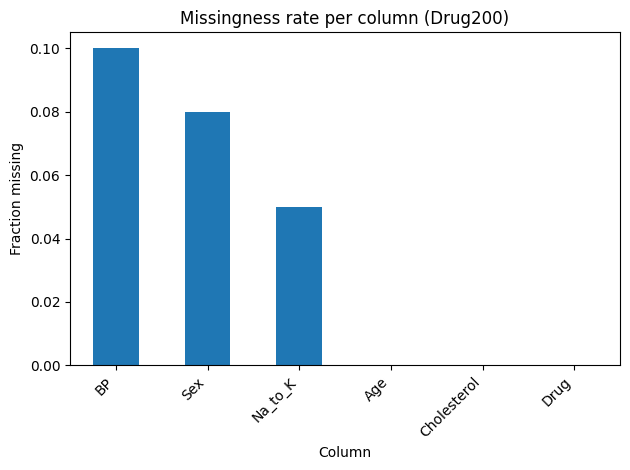

In [5]:
# Visualize missingness per column (simple bar plot)
plt.figure()
missing_rates.plot(kind="bar")
plt.title("Missingness rate per column (Drug200)")
plt.xlabel("Column")
plt.ylabel("Fraction missing")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



### ۲.۱ ساخت خط‌لوله‌ها (بدون leakage)

یک روند **بدون leakage** یعنی:
- ابتدا train/test را جدا کنید (یا از CV استفاده کنید).
- imputerها و encoderها را **فقط روی foldهای آموزشی** fit کنید.
- سپس همان تبدیلِ fit‌شده را روی validation/test اعمال کنید.

`Pipeline` و `ColumnTransformer` این نظم را تحمیل می‌کنند.


In [6]:
X = df.drop(columns=["Drug"])
y = df["Drug"]

# Identify columns by type
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

cat_cols, num_cols


(['Sex', 'BP', 'Cholesterol'], ['Age', 'Na_to_K'])

In [7]:
# Train/test split (stratified for classification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Baseline: drop rows with any missing values (train and test separately)
train_mask = X_train.notna().all(axis=1)
test_mask  = X_test.notna().all(axis=1)

X_train_drop = X_train.loc[train_mask].copy()
y_train_drop = y_train.loc[train_mask].copy()
X_test_drop  = X_test.loc[test_mask].copy()
y_test_drop  = y_test.loc[test_mask].copy()

baseline_clf = DecisionTreeClassifier(random_state=42, max_depth=5)
baseline_clf.fit(pd.get_dummies(X_train_drop, drop_first=False), y_train_drop)

# Align dummy columns between train and test
X_test_dum = pd.get_dummies(X_test_drop, drop_first=False)
X_train_dum = pd.get_dummies(X_train_drop, drop_first=False)
X_test_dum = X_test_dum.reindex(columns=X_train_dum.columns, fill_value=0)

y_pred_base = baseline_clf.predict(X_test_dum)

print("Baseline (drop missing rows + get_dummies)")
print("Test accuracy:", accuracy_score(y_test_drop, y_pred_base))


Baseline (drop missing rows + get_dummies)
Test accuracy: 0.975609756097561


In [8]:
# Pipeline A: Impute + OneHot + Decision Tree
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess_A = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

pipe_A = Pipeline(steps=[
    ("preprocess", preprocess_A),
    ("model", DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=5)),
])

pipe_A.fit(X_train, y_train)
y_pred_A = pipe_A.predict(X_test)

print("Pipeline A (median/mode impute + one-hot)")
print("Test accuracy:", accuracy_score(y_test, y_pred_A))


Pipeline A (median/mode impute + one-hot)
Test accuracy: 0.98



### ۲.۲ یک روش ساده برای اینکه درخت «missingness را ببیند»

یک ترفند مقاوم برای categoricalها این است که missing را با یک توکن ثابت (مثلاً `"__MISSING__"`) impute کنیم. بعد از one-hot، این کار یک ستونِ مجزا می‌سازد که درخت می‌تواند روی آن split بزند.

برای عددی‌ها می‌توان indicator صریح اضافه کرد، اما برای کم‌کردن وابستگی‌ها در این درس، همین روشِ indicator برای categorical را نشان می‌دهیم (و برای indicator عددی در بخش مفهومی توضیح دادیم).


In [9]:
# Pipeline B: Impute categorical with a constant token so missingness becomes a category
categorical_transformer_B = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess_B = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),  # numeric still median-imputed
        ("cat", categorical_transformer_B, cat_cols),
    ]
)

pipe_B = Pipeline(steps=[
    ("preprocess", preprocess_B),
    ("model", DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=5)),
])

pipe_B.fit(X_train, y_train)
y_pred_B = pipe_B.predict(X_test)

print("Pipeline B (constant categorical impute => missing indicator via one-hot)")
print("Test accuracy:", accuracy_score(y_test, y_pred_B))


Pipeline B (constant categorical impute => missing indicator via one-hot)
Test accuracy: 0.96


In [10]:
print("Classification report (Pipeline B)")
print(classification_report(y_test, y_pred_B))

cm = confusion_matrix(y_test, y_pred_B)
cm_df = pd.DataFrame(cm, index=pipe_B.classes_, columns=pipe_B.classes_)
cm_df


Classification report (Pipeline B)
              precision    recall  f1-score   support

       DrugY       0.96      1.00      0.98        23
       drugA       1.00      1.00      1.00         6
       drugB       1.00      0.75      0.86         4
       drugC       1.00      1.00      1.00         4
       drugX       0.92      0.92      0.92        13

    accuracy                           0.96        50
   macro avg       0.98      0.93      0.95        50
weighted avg       0.96      0.96      0.96        50



,DrugY,drugA,drugB,drugC,drugX
DrugY,23,0,0,0,0
drugA,0,6,0,0,0
drugB,0,0,3,0,1
drugC,0,0,0,4,0
drugX,1,0,0,0,12



### ۲.۳ مشاهده‌ی قواعد یادگرفته‌شده

درخت‌ها ساده و قابل بازرسی‌اند. بعد از پیش‌پردازش، می‌توان مدل را بیرون کشید و خلاصه‌ای متنی از قواعد split را چاپ کرد.

نکته: بعد از one-hot، نام ویژگی‌ها زیاد می‌شود؛ ما نام‌ها را از `ColumnTransformer` بازسازی می‌کنیم.


In [11]:
# Helper to recover feature names after ColumnTransformer
def get_feature_names_from_column_transformer(ct: ColumnTransformer):
    output_features = []
    for name, trans, cols in ct.transformers_:
        if name == "remainder":
            continue
        if hasattr(trans, "named_steps"):
            last = list(trans.named_steps.values())[-1]
        else:
            last = trans
        if hasattr(last, "get_feature_names_out"):
            try:
                fn = last.get_feature_names_out(cols)
            except TypeError:
                fn = last.get_feature_names_out()
            output_features.extend(fn.tolist())
        else:
            # Numeric pipeline typically doesn't change names
            if isinstance(cols, (list, tuple)):
                output_features.extend(list(cols))
            else:
                output_features.append(str(cols))
    return output_features

ct = pipe_B.named_steps["preprocess"]
feature_names = get_feature_names_from_column_transformer(ct)

dt = pipe_B.named_steps["model"]
rules = export_text(dt, feature_names=feature_names, max_depth=3)
print(rules[:4000])


|--- Na_to_K <= 14.63
|   |--- BP_HIGH <= 0.50
|   |   |--- BP_LOW <= 0.50
|   |   |   |--- BP_NORMAL <= 0.50
|   |   |   |   |--- class: drugX
|   |   |   |--- BP_NORMAL >  0.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- BP_LOW >  0.50
|   |   |   |--- Cholesterol_HIGH <= 0.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- Cholesterol_HIGH >  0.50
|   |   |   |   |--- class: drugC
|   |--- BP_HIGH >  0.50
|   |   |--- Age <= 50.00
|   |   |   |--- Age <= 28.50
|   |   |   |   |--- class: drugA
|   |   |   |--- Age >  28.50
|   |   |   |   |--- class: drugA
|   |   |--- Age >  50.00
|   |   |   |--- class: drugB
|--- Na_to_K >  14.63
|   |--- class: DrugY




## ۳) متغیرهای دسته‌ای در درخت‌ها: گزینه‌ها و بده‌بستان‌ها

### ۳.۱ One-hot encoding (OHE)
**مزایا**
- ترتیبِ ساختگی ایجاد نمی‌کند.
- برای cardinality کم/متوسط خوب کار می‌کند.
- splitها قابل تفسیرند (مثلاً `BP_HIGH` در برابر غیر از آن).

**معایب**
- در cardinality بالا، تعداد ستون‌ها منفجر می‌شود (هزینه‌ی حافظه/زمان).
- درخت ممکن است با split روی دسته‌های بسیار نادر overfit شود.

### ۳.۲ Ordinal encoding
دسته‌ها به عدد نگاشت می‌شوند (مثلاً `LOW→0`، `NORMAL→1`، `HIGH→2`).

**مزایا**
- فشرده و سریع.
- وقتی ترتیب واقعی وجود دارد (مثل سطح تحصیلات) مناسب است.

**معایب**
- اگر ترتیب واقعی نباشد، یک **ترتیب ساختگی** تزریق می‌کند.
- درخت ممکن است splitهای آستانه‌ای بسازد که گروه‌بندی دسته‌ها را ناخواسته تغییر دهد.

### ۳.۳ Frequency / count encoding
هر دسته با فراوانی‌اش در داده‌ی آموزش جایگزین می‌شود.

**مزایا**
- بسیار فشرده.
- برای ویژگی‌های با cardinality بالا گاهی surprisingly خوب است.
- «نادر بودن» را کد می‌کند که در بسیاری از مسائل با خروجی مرتبط است.

**معایب**
- هویت دسته‌ها از بین می‌رود؛ دو دسته با فراوانی یکسان indistinguishable می‌شوند.

### ۳.۴ Target encoding (mean encoding)
هر دسته با میانگین هدف برای آن دسته جایگزین می‌شود (برای طبقه‌بندی دودویی: نرخ مثبت؛ برای رگرسیون: میانگین $y$).

**مزایا**
- برای cardinality بالا قدرتمند است.

**معایب (بسیار مهم!)**
- اگر میانگین‌ها را با کل داده حساب کنید، leakage شدید ایجاد می‌شود.
- باید out-of-fold انجام شود یا با smoothing و نظمِ CV کنترل شود.



## ۴) مثال ۲ (رگرسیون): `house-prices.csv`

اکنون به یک مسئله‌ی رگرسیون می‌رویم. این دیتاست شامل:
- عددی: `SqFt`, `Bedrooms`, `Bathrooms`, `Offers`
- دسته‌ای: `Brick`, `Neighborhood`
- هدف: `Price`

کارهایی که انجام می‌دهیم:
- تزریق missingness در `Brick` و `SqFt`.
- مقایسه‌ی one-hot با ordinal برای `Neighborhood`.
- ارزیابی با MAE و RMSE.


In [12]:
path_house = "../../../Datasets/Regression/house-prices.csv"
df_house = pd.read_csv(path_house)

df_house.head()


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [13]:
df2 = df_house.copy()
rng = np.random.default_rng(123)

# Inject some missingness
n2 = len(df2)
df2.loc[rng.choice(n2, size=max(1, int(0.08*n2)), replace=False), "Brick"] = np.nan
df2.loc[rng.choice(n2, size=max(1, int(0.05*n2)), replace=False), "SqFt"] = np.nan

df2.isna().mean().sort_values(ascending=False)


Brick           0.078125
SqFt            0.046875
Price           0.000000
Home            0.000000
Bedrooms        0.000000
Bathrooms       0.000000
Offers          0.000000
Neighborhood    0.000000
dtype: float64

In [14]:
Xh = df2.drop(columns=["Price"])
yh = df2["Price"]

cat_cols_h = Xh.select_dtypes(include=["object"]).columns.tolist()
num_cols_h = [c for c in Xh.columns if c not in cat_cols_h]

Xh_train, Xh_test, yh_train, yh_test = train_test_split(
    Xh, yh, test_size=0.25, random_state=42
)

numeric_trans_h = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

# One-hot version
cat_trans_ohe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess_ohe = ColumnTransformer(
    transformers=[
        ("num", numeric_trans_h, num_cols_h),
        ("cat", cat_trans_ohe, cat_cols_h),
    ]
)

pipe_ohe = Pipeline(steps=[
    ("preprocess", preprocess_ohe),
    ("model", DecisionTreeRegressor(random_state=42, max_depth=6, min_samples_leaf=5)),
])

pipe_ohe.fit(Xh_train, yh_train)
pred_ohe = pipe_ohe.predict(Xh_test)

mae_ohe = mean_absolute_error(yh_test, pred_ohe)
rmse_ohe = root_mean_squared_error(yh_test, pred_ohe)

mae_ohe, rmse_ohe


(np.float64(10255.600198412696), np.float64(14559.534126574883))

In [15]:
# Ordinal encoding version for categoricals (compact, but may impose false order)
cat_trans_ord = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
])

preprocess_ord = ColumnTransformer(
    transformers=[
        ("num", numeric_trans_h, num_cols_h),
        ("cat", cat_trans_ord, cat_cols_h),
    ]
)

pipe_ord = Pipeline(steps=[
    ("preprocess", preprocess_ord),
    ("model", DecisionTreeRegressor(random_state=42, max_depth=6, min_samples_leaf=5)),
])

pipe_ord.fit(Xh_train, yh_train)
pred_ord = pipe_ord.predict(Xh_test)

mae_ord = mean_absolute_error(yh_test, pred_ord)
rmse_ord = root_mean_squared_error(yh_test, pred_ord)

mae_ord, rmse_ord


(np.float64(9346.755952380952), np.float64(12815.69685188128))


### ۴.۱ تفسیر

ممکن است بسته به عوامل زیر هر کدام از encodingها بهتر شوند:
- اندازه‌ی دیتاست (این دیتاست کوچک است)،
- عمق درخت / حداقل اندازه‌ی برگ،
- میزان سیگنالِ ویژگی دسته‌ای،
- و اینکه آیا ترتیبِ تحمیلیِ ordinal به‌طور تصادفی کمک می‌کند یا آسیب می‌زند.

در حالت کلی:
- **OHE** انتخاب امن وقتی تعداد دسته‌ها زیاد نیست.
- **Ordinal** وقتی ترتیب طبیعی دارید یا وقتی ظرفیت مدل را محکم کنترل می‌کنید (درخت کم‌عمق، `min_samples_leaf` بزرگ‌تر) می‌تواند قابل قبول باشد.

حالا به موضوع پیشرفته‌تری می‌رویم: **Target encoding** برای categoricalهای با cardinality بالا.



## ۵) Target encoding بدون leakage (پیشرفته اما کاربردی)

Target encoding یک دسته را با یک آماره از هدف برای همان دسته جایگزین می‌کند.

برای رگرسیون، شکل ساده‌ی آن:

$$
\text{TE}(c) = \mathbb{E}[y \mid x=c]
$$

برای طبقه‌بندی دودویی، معمولاً نرخ مثبت $\mathbb{P}(y=1 \mid x=c)$ است.

### چرا leakage رخ می‌دهد؟
اگر $\mathbb{E}[y \mid x=c]$ را با کل داده حساب کنید و سپس مدل را آموزش دهید، برای هر نمونه اطلاعاتی از برچسب همان نمونه در encoding وجود دارد (خصوصاً برای دسته‌های نادر). نتیجه: نمره‌ی اعتبارسنجی غیرواقعی بالا و عملکرد بد در دنیای واقعی.

### راه‌حل: encoding به‌صورت out-of-fold
در cross-validation:
- در هر fold، میانگین‌های دسته‌ها را فقط با **داده‌ی آموزشی همان fold** بسازید.
- سپس روی داده‌ی اعتبارسنجی اعمال کنید.
- در صورت نیاز با smoothing، میانگین‌های دسته‌های کم‌نمونه را به میانگین کلی نزدیک کنید.

در ادامه یک پیاده‌سازی مینیمال و بدون وابستگی اضافه ارائه می‌شود که با pipelineهای scikit-learn کار می‌کند.


In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetMeanEncoderOOF(BaseEstimator, TransformerMixin):
    """Out-of-fold target mean encoder for a single categorical column.

    - During fit_transform(X_train, y_train): produces OOF encodings (no self-leakage).
    - During transform(X_test): uses mapping fitted on full training data.
    - Uses smoothing to shrink rare-category means toward the global mean.
    """
    def __init__(self, smoothing=20.0, n_splits=5, random_state=42):
        self.smoothing = float(smoothing)
        self.n_splits = int(n_splits)
        self.random_state = int(random_state)

    def _fit_mapping(self, s, y):
        global_mean = y.mean()
        stats = y.groupby(s).agg(["mean", "count"])
        stats["smooth"] = (stats["count"] * stats["mean"] + self.smoothing * global_mean) / (stats["count"] + self.smoothing)
        mapping = stats["smooth"].to_dict()
        return global_mean, mapping

    def fit(self, X, y):
        X_df = pd.DataFrame(X)
        s = X_df.iloc[:, 0].astype("object")
        y = pd.Series(y).reset_index(drop=True)
        self.global_mean_, self.mapping_ = self._fit_mapping(s, y)
        return self

    def fit_transform(self, X, y):
        X_df = pd.DataFrame(X)
        s = X_df.iloc[:, 0].astype("object").reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)

        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        oof = np.empty(len(y), dtype=float)

        for tr_idx, va_idx in kf.split(s):
            s_tr, y_tr = s.iloc[tr_idx], y.iloc[tr_idx]
            global_mean, mapping = self._fit_mapping(s_tr, y_tr)
            enc = s.iloc[va_idx].map(mapping).fillna(global_mean).astype(float)
            oof[va_idx] = enc.values

        # Fit mapping on full data for later transform
        self.global_mean_, self.mapping_ = self._fit_mapping(s, y)

        return pd.DataFrame(oof, columns=["__target_mean"])

    def transform(self, X):
        X_df = pd.DataFrame(X)
        s = X_df.iloc[:, 0].astype("object")
        out = s.map(self.mapping_).fillna(self.global_mean_).astype(float)
        return out.to_frame(name="__target_mean")



## ۶) مثال ۳ (رگرسیون + categorical با cardinality بالا): `listings.csv`

این دیتاست ستون‌های دسته‌ای زیادی دارد (مثلاً محله‌ها و نوع اتاق). categoricalهای با cardinality بالا در مسائل واقعی بسیار رایج‌اند (کاربرها، کالاها، مکان‌ها).

کارهایی که انجام می‌دهیم:
- یک مسئله‌ی رگرسیون ساده می‌سازیم: پیش‌بینی `price` با چند ویژگی منتخب.
- مقایسه‌ی:
  - One-hot encoding
  - Frequency encoding
  - Target encoding (encoder ایمن ما)

برای معقول‌بودن زمان اجرا، از نمونه‌گیری استفاده می‌کنیم.


In [17]:
path_listings = "../../../Datasets/Regression/listings.csv"
df_list = pd.read_csv(path_listings)

# Basic cleanup: ensure numeric price
df_list["price"] = pd.to_numeric(df_list["price"], errors="coerce")

# Choose a subset of features (mix of numeric + categorical)
use_cols = ["latitude", "longitude", "minimum_nights", "number_of_reviews", "room_type", "neighbourhood"]
df_list = df_list[use_cols + ["price"]].dropna(subset=["price"]).copy()

# Sample for speed (adjust as needed) and RESET INDEX to avoid .loc KeyError later
df_list = df_list.sample(n=min(3000, len(df_list)), random_state=42).reset_index(drop=True)

df_list.head()


,latitude,longitude,minimum_nights,number_of_reviews,room_type,neighbourhood,price
0,51.490900,-0.137670,2,20,Entire home/apt,Westminster,244.0
1,51.517378,0.012742,1,20,Private room,Newham,51.0
2,51.498490,-0.181320,1,42,Entire home/apt,Kensington and Chelsea,338.0
3,51.466316,0.112080,1,1,Entire home/apt,Bexley,152.0
4,51.539760,-0.165780,5,2,Entire home/apt,Camden,131.0


In [18]:
# Inject a bit of missingness into categoricals to demonstrate handling
rng = np.random.default_rng(7)
n3 = len(df_list)

# IMPORTANT: df_list index is 0..n3-1 (we reset_index above), so .loc with idx works safely.
for col, rate in [("room_type", 0.05), ("neighbourhood", 0.05)]:
    idx = rng.choice(n3, size=max(1, int(rate*n3)), replace=False)
    df_list.loc[idx, col] = np.nan

df_list.isna().mean().sort_values(ascending=False)


room_type            0.05
neighbourhood        0.05
latitude             0.00
minimum_nights       0.00
longitude            0.00
number_of_reviews    0.00
price                0.00
dtype: float64

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    """Frequency (count) encoder for a single categorical column.

    Works with:
    - pandas DataFrame (single column)
    - numpy array with shape (n_samples, 1) (common after SimpleImputer)
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        s = X_df.iloc[:, 0].astype("object")
        freqs = s.value_counts(dropna=False)
        self.mapping_ = (freqs / freqs.sum()).to_dict()
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X)
        s = X_df.iloc[:, 0].astype("object")
        out = s.map(self.mapping_).fillna(0.0).astype(float)
        return out.to_frame(name="__freq")


In [20]:
Xl = df_list.drop(columns=["price"])
yl = df_list["price"]

cat_cols_l = Xl.select_dtypes(include=["object"]).columns.tolist()
num_cols_l = [c for c in Xl.columns if c not in cat_cols_l]

Xl_train, Xl_test, yl_train, yl_test = train_test_split(Xl, yl, test_size=0.25, random_state=42)

numeric_trans_l = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

# --- One-hot pipeline ---
cat_ohe_l = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

pre_ohe_l = ColumnTransformer([
    ("num", numeric_trans_l, num_cols_l),
    ("cat", cat_ohe_l, cat_cols_l),
])

pipe_ohe_l = Pipeline(steps=[
    ("preprocess", pre_ohe_l),
    ("model", DecisionTreeRegressor(random_state=42, max_depth=8, min_samples_leaf=20)),
])

pipe_ohe_l.fit(Xl_train, yl_train)
pred_ohe_l = pipe_ohe_l.predict(Xl_test)

mae_ohe_l = mean_absolute_error(yl_test, pred_ohe_l)
rmse_ohe_l = root_mean_squared_error(yl_test, pred_ohe_l)

# --- Frequency encoding pipeline (per categorical column) ---
pre_freq_l = ColumnTransformer(
    [("num", numeric_trans_l, num_cols_l)] +
    [(f"freq_{c}", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
        ("freq", FrequencyEncoder()),
    ]), [c]) for c in cat_cols_l]
)

pipe_freq_l = Pipeline(steps=[
    ("preprocess", pre_freq_l),
    ("model", DecisionTreeRegressor(random_state=42, max_depth=8, min_samples_leaf=20)),
])

pipe_freq_l.fit(Xl_train, yl_train)
pred_freq_l = pipe_freq_l.predict(Xl_test)

mae_freq_l = mean_absolute_error(yl_test, pred_freq_l)
rmse_freq_l = root_mean_squared_error(yl_test, pred_freq_l)

# --- Target mean encoding (OOF) pipeline ---
pre_te_l = ColumnTransformer(
    [("num", numeric_trans_l, num_cols_l)] +
    [(f"te_{c}", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
        ("te", TargetMeanEncoderOOF(smoothing=20.0, n_splits=5, random_state=42)),
    ]), [c]) for c in cat_cols_l]
)

pipe_te_l = Pipeline(steps=[
    ("preprocess", pre_te_l),
    ("model", DecisionTreeRegressor(random_state=42, max_depth=8, min_samples_leaf=20)),
])

pipe_te_l.fit(Xl_train, yl_train)
pred_te_l = pipe_te_l.predict(Xl_test)

mae_te_l = mean_absolute_error(yl_test, pred_te_l)
rmse_te_l = root_mean_squared_error(yl_test, pred_te_l)

pd.DataFrame({
    "Encoding": ["OneHot", "Frequency", "TargetMean(OOF)"],
    "MAE": [mae_ohe_l, mae_freq_l, mae_te_l],
    "RMSE": [rmse_ohe_l, rmse_freq_l, rmse_te_l],
})


,Encoding,MAE,RMSE
0,OneHot,81.987527,148.026645
1,Frequency,84.202082,151.403117
2,TargetMean(OOF),85.993144,150.802625



### ۶.۱ جمع‌بندی

- One-hot وقتی cardinality متوسط است و داده کافی دارید معمولاً خوب است، اما می‌تواند سنگین شود.
- Frequency encoding یک baseline فشرده و ارزان است که گاهی به‌طور غیرمنتظره‌ای خوب عمل می‌کند.
- Target encoding برای cardinality بالا می‌تواند قوی باشد، اما ارزش واقعی آن به این‌ها وابسته است:
  - داده‌ی کافی برای هر دسته،
  - پیاده‌سازی بدون leakage,
  - و smoothing / regularization مناسب.

**قاعده‌ی سرانگشتی:** با OHE شروع کنید؛ اگر صدها/هزاران دسته دارید (مثل user ID، item ID، neighborhoods)، frequency یا target encoding را با cross-validation منظم ارزیابی کنید.



## ۷) بهترین‌روش‌ها (درخت‌ها + missing + categorical)

### مقادیر گمشده
- **ساده شروع کنید:** impute با میانه/مد.
- برای categorical، بهتر است یک توکن مشخص `"__MISSING__"` داشته باشید تا بعد از OHE به یک ویژگی صریح تبدیل شود.
- اگر missingness اطلاعات‌دار است، indicator اضافه کنید.
- برای جلوگیری از leakage از pipeline استفاده کنید.

### ویژگی‌های دسته‌ای
- پیش‌فرض: **OneHotEncoder(handle_unknown="ignore")**.
- اگر cardinality خیلی بالا است:
  - **frequency** یا **target encoding** را تست کنید،
  - برای target encoding از out-of-fold و smoothing استفاده کنید،
  - ظرفیت درخت را کنترل کنید: `max_depth`, `min_samples_leaf`, `min_samples_split`.

### کنترل ظرفیت (برای جلوگیری از overfitting روی دسته‌های نادر)
- `min_samples_leaf` را افزایش دهید (خیلی مؤثر است).
- `max_depth` را محدود کنید.
- pruning یا ensembleها را در نظر بگیرید (فصل بعد).



## ۸) تمرین‌ها (با راهنمایی)

1. **پایداری Drug200**
   - missingness را برای `BP` تا ۲۰٪ و برای `Sex` تا ۲۰٪ افزایش دهید.
   - خط‌لوله A و B را دوباره مقایسه کنید.
   - کدام خط‌لوله کندتر افت می‌کند؟ چرا؟

2. **حساسیت house prices**
   - `max_depth` را از ۲ تا ۱۲ برای خط‌لوله‌ی OHE تغییر دهید.
   - عمق در برابر RMSE را رسم کنید.
   - الگوی بایاس–واریانس را توضیح دهید.

3. **آزمایش cardinality بالا**
   - در `listings.csv` ستون `neighbourhood_group` (اگر موجود است) را اضافه کنید و encodingها را دوباره مقایسه کنید.
   - مقادیر smoothing مختلف برای `TargetMeanEncoder` امتحان کنید (مثلاً ۱، ۱۰، ۵۰، ۲۰۰).

4. **چالش دیتاست جدید**
   - از `../../../Datasets/Classification/stars.csv` (categorical: `Color`, `Spectral_Class`) برای پیش‌بینی `Type` استفاده کنید.
   - یک خط‌لوله‌ی طبقه‌بندی با constant-impute + OHE بسازید.
   - اگر عدم‌تعادل دیدید، وزن‌دهی کلاس‌ها یا کنترل عمق را امتحان کنید.

5. **گزارش کوتاه**
   - در ۵ تا ۱۰ بولت، توصیه‌ی نهایی خود را برای «درخت‌ها + missing + categorical» در یک پروژه‌ی واقعی بنویسید.



### ادامه‌ی مسیر

در درس بعد درباره‌ی **پایداری و واریانس درخت‌ها** صحبت می‌کنیم: اینکه چرا تغییرات کوچک در داده می‌تواند درخت‌های متفاوت بسازد و چرا این موضوع انگیزه‌ی bagging و random forests است.
